# **Chatbot for Mental Health Awareness using NLP and Deep Learning**

For our first codewalk, we experimented with retreival based models for our chatbots using a collection of mental health data - conversations between therapists and clients to help our model better understand and respond to messages appropriately. The project layout is as follows :


1.   Data Preprocessing
2.   Model Building (Sequence to Sequence Neural Networks)
3.   Predicting Responses







# Data Preprocessing 

Data Preprocessing 

The data used to train our model is in the form of json intents - which contain tag - which represents the type of text, pattern - which represents the texts belonging to that paticular type and responses - containing appropriate responses for the tags and patterns. 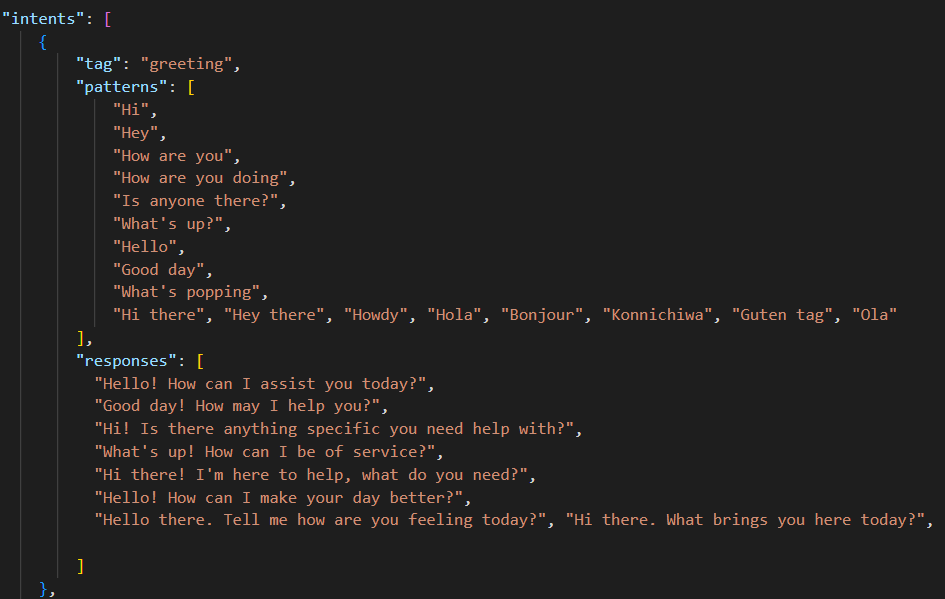

To make the data ready for model building, it is first preprocessed and converted into numerical format - vectors using the bag of words technique.The json file is parsed to obtain the respective "tag", "patterns", and "responses" as keys and this is preprocessed - 

*   All text is converted to lowercase and processed with regular expressions to remove unwanted characters
*   Sentences are tokenized to obtain words
*   Tokenized words are lemmatized(Lemmatisation  is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form) to create a vocabulary of wordsfor the model to learn from (lemmatization is chosen over stemming as context of words matter for the chatbot to respond appropriatley)



**Bag of words**


In the Bag of Words or BOW model, documents are converted into vectors to be used by Neural Networks.Based on the vocabulary created from data preprocessing, vectors of size of the vocabulary is created for each sentence and the presence of the word in the vector is marked with  boolean value, 0 for absent, 1 for present.  

For example, a sentence converted to a vector format will look as follows :  

"it was the worst of times" = [1, 1, 1, 0, 1, 1, 1, 0, 0, 0]


In [ ]:
import json 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import pickle
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.nn.functional as F
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
ignore_words = ['?', '!']
data_file = open('intents.json').read()
intents = json.loads(data_file)

In [ ]:
#Extracting the data from json file
words=[]
classes = []
documents = []
for intent in intents['intents']:
    for pattern in intent['patterns']:
        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])


In [ ]:
# lemmatize, lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)

pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))


224 documents
47 classes ['about', 'addiction', 'afternoon', 'anxiety', 'ask', 'casual', 'death', 'default', 'depression', 'done', 'evening', 'friends', 'funny', 'goodbye', 'greeting', 'happy', 'hate-me', 'hate-you', 'help', 'jokes', 'learn-more', 'location', 'meditation', 'morning', 'name', 'neutral-response', 'night', 'no-approach', 'no-response', 'not-talking', 'problem', 'repeat', 'scared', 'schizophrenia', 'skill', 'sleep', 'something-else', 'stressed', 'stupid', 'suicide', 'thanks', 'understand', 'user-advice', 'user-agree', 'user-meditation', 'worthless', 'wrong']
265 unique lemmatized words ["'m", "'re", "'s", "'ve", ',', '.', 'a', 'about', 'absolutely', 'addicted', 'addiction', 'advice', 'afternoon', 'all', 'alot', 'already', 'am', 'an', 'and', 'another', 'answer', 'anxiety', 'anxious', 'any', 'anymore', 'anyone', 'anything', 'appreciate', 'approaching', 'are', 'ask', 'au', 'away', 'awesome', 'awful', 'be', 'because', 'better', 'bonjour', 'boyfriend', 'break', 'bring', 'brothe

In [ ]:
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


<ipython-input-5-c9d0c66fbd72>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


In [ ]:
#bag

In [ ]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('chatbot_model.h5', hist)

print("model created")

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
45/45 [==============================] - 1s 2ms/step - loss: 3.8381 - accuracy: 0.0402
Epoch 2/200
45/45 [==============================] - 0s 2ms/step - loss: 3.7174 - accuracy: 0.1027
Epoch 3/200
45/45 [==============================] - 0s 2ms/step - loss: 3.6302 - accuracy: 0.0714
Epoch 4/200
45/45 [==============================] - 0s 2ms/step - loss: 3.5173 - accuracy: 0.0893
Epoch 5/200
45/45 [==============================] - 0s 1ms/step - loss: 3.3895 - accuracy: 0.1250
Epoch 6/200
45/45 [==============================] - 0s 1ms/step - loss: 3.2505 - accuracy: 0.1429
Epoch 7/200
45/45 [==============================] - 0s 2ms/step - loss: 3.1042 - accuracy: 0.1741
Epoch 8/200
45/45 [==============================] - 0s 2ms/step - loss: 2.9953 - accuracy: 0.2500
Epoch 9/200
45/45 [==============================] - 0s 2ms/step - loss: 2.8100 - accuracy: 0.2366
Epoch 10/200
45/45 [==============================] - 0s 2ms/step - loss: 2.6493 - accuracy: 0.2991
Epoch 11/

In [ ]:
from keras.models import load_model
import pickle
model = load_model('chatbot_model.h5')
import json
import random
intents = json.loads(open('intents.json').read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))

In [ ]:
def clean_up_sentence(sentence):
    # tokenize the pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word - create short form for word
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words
# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence





In [ ]:
def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words) 
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))

In [ ]:
def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

In [ ]:
def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

def chatbot_response(text):
    ints = predict_class(text, model)
    res = getResponse(ints, intents)
    return res

In [ ]:
while True:
    new_input = input("You: ")
    if new_input == 'exit':
        break
    response = chatbot_response(new_input)
    print("Buddy:", response)

You: hello
1/1 [==============================] - 0s 76ms/step
Buddy: Hi there. What brings you here today?
You: I', depressed
1/1 [==============================] - 0s 19ms/step
Buddy: Sometimes when we are depressed, it is hard to care about anything. It can be hard to do the simplest of things. Give yourself time to heal.
You: I feel anxious
1/1 [==============================] - 0s 19ms/step
Buddy: At the highest level, anxiety is your body's natural response to stress. It's a feeling of fear or apprehension about what's to come. The first day of school, going to a job interview, or giving a speech may cause most people to feel fearful and nervous. We all get anxious sometimes, but anxiety becomes a problem when it starts affecting your daily life drastically. The best thing that you can do to help reduce anxiety is to take a few deep breaths and talk to someone about what you're feeling. Some natural remedies that you can try include: getting enough sleep, meditating, staying acti